<a href="https://colab.research.google.com/github/AtsushiNi/myLeprecon/blob/master/niihama/analyze_12-17/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要
12/17のデータの前処理<br>
波長校正、発光強度を計算し、ファイルに保存する

In [ ]:
!pip install git+https://github.com/fujiisoup/pyspectra.git
!pip install netCDF4

  Cloning https://github.com/fujiisoup/pyspectra.git to /tmp/pip-req-build-w4yua5k8
  Running command git clone -q https://github.com/fujiisoup/pyspectra.git /tmp/pip-req-build-w4yua5k8
  Created wheel for pyspectra: filename=pyspectra-0.0.1-cp36-none-any.whl size=18787 sha256=259ecace8299753b543e02bfb571cb987e9854a3bfbd8a896a29b18b28275e5b
  Stored in directory: /tmp/pip-ephem-wheel-cache-sd8syu1o/wheels/a7/c4/4a/152e6df7ccc3c6838abee31c086e30a3690c80966eb588e7a2
Successfully built pyspectra
     |████████████████████████████████| 4.7MB 5.6MB/s 
     |████████████████████████████████| 296kB 42.5MB/s 


In [ ]:
import os
from os.path import join
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyspectra
from scipy import interpolate
from scipy import integrate

In [ ]:
data_path = '/content/drive/MyDrive/研究室/myLeprecon/SpectrometerData/20201217_niihama'
print(os.path.exists(data_path))

True


In [ ]:
file_names = [f'H_{430000 + 5000*i}.nc' for i in range(8)]
data = []
for file_name in file_names:
    data_array = xr.open_dataarray(join(data_path, file_name))
    data_array['motor_coordinate'] = data_array.attrs['motor_coordinate']
    data_array['exposure'] = data_array.attrs['exposure']
    data.append(data_array)
data = xr.concat(data, dim='motor_coordinate')

plasma_data = []
for i, p in enumerate(data['motor_coordinate']):
  d = data.sel(motor_coordinate=p).copy()
  d['long_x'] = d['x'][::-1] - 1000 * i
  d['x'] = data['x']
  plasma_data.append(d.sum('y'))
plasma_data = xr.concat(plasma_data, dim='motor_coordinate')

In [ ]:
file_names = [f'back_{430000 + 5000*i}.nc' for i in range(8)]
data = []
for file_name in file_names:
    data_array = xr.open_dataarray(join(data_path, file_name))
    data_array['motor_coordinate'] = data_array.attrs['motor_coordinate']
    data_array['exposure'] = data_array.attrs['exposure']
    data.append(data_array)
data = xr.concat(data, dim='motor_coordinate')

back_data = []
for i, p in enumerate(data['motor_coordinate']):
    d = data.sel(motor_coordinate=p).copy()
    d['long_x'] = d['x'][::-1] - 1000 * i
    d['x'] = data['x']
    back_data.append(d.sum('y'))
back_data = xr.concat(back_data, dim='motor_coordinate')

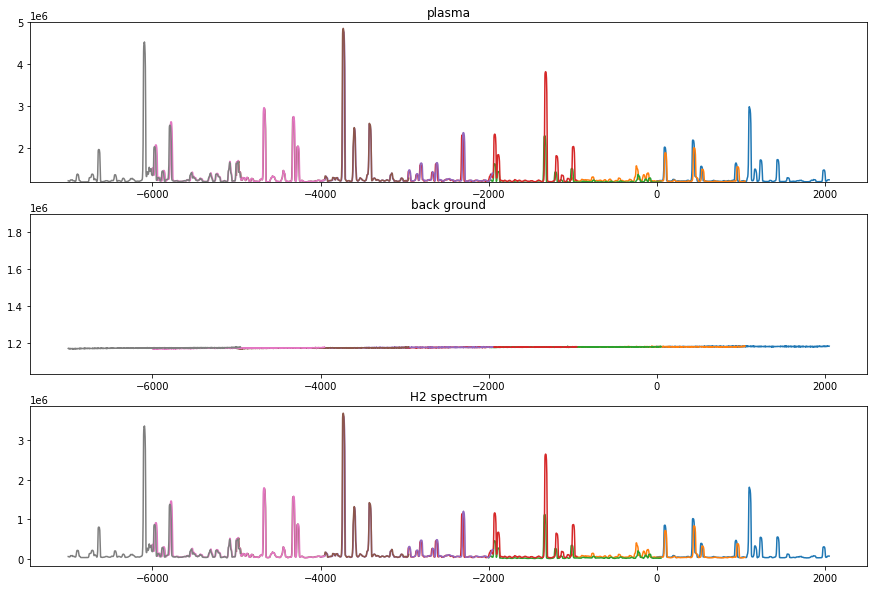

In [ ]:
spectrum_data = plasma_data - back_data * 1.0

plt.figure(figsize=[15, 10])
plt.subplot(3, 1, 1)
plt.ylim(1.2*1e6, 5*1e6)
plt.title('plasma')
for f in plasma_data:
  plt.plot(f['long_x'], f)

plt.subplot(3, 1, 2)
plt.title('back ground')
plt.ylim(1.03*1e6, 1.9*1e6)
for f in back_data:
  plt.plot(f['long_x'], f)

plt.subplot(3, 1, 3)
plt.title('H2 spectrum')
for f in spectrum_data:
  plt.plot(f['long_x'], f)

# 波長校正

In [ ]:
def fit(da):
  popt, perr = pyspectra.fit.singlepeak_fit(da['x'].values, da.values)
  return xr.Dataset({
      'A': popt[0], 'x0': popt[1], 'w': popt[2], 'y0': popt[3],
      'data': da,
      'fit': ('x', pyspectra.profiles.Gauss(da['x'].values, *popt))},
      coords={'x': da['x']})

## (v' - v") = (0 - 0)

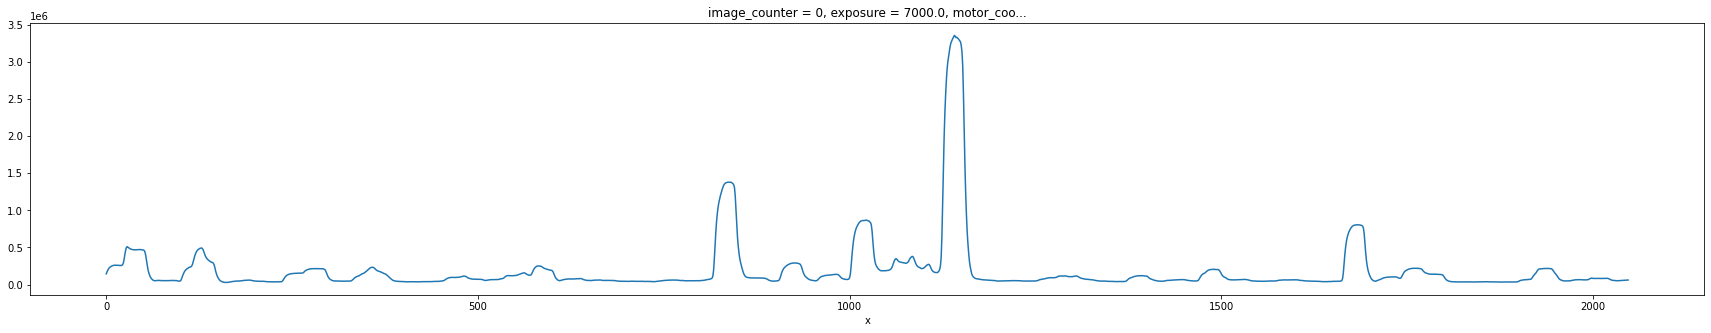

In [ ]:
plt.figure(figsize=(30, 5))
spectrum_data.sel(motor_coordinate=465000).plot()

Text(0, 0.5, 'wave length (nm)')

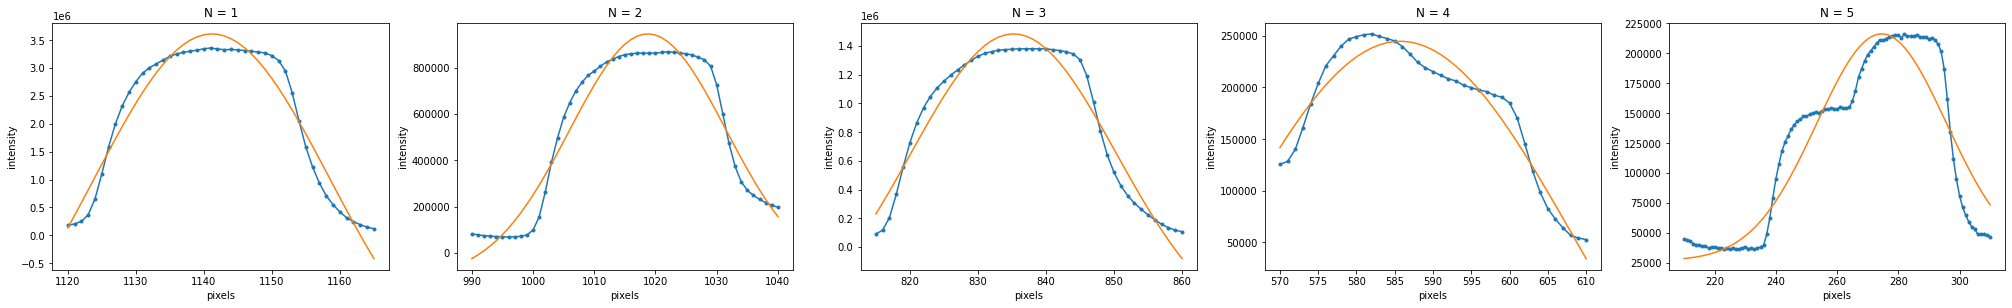

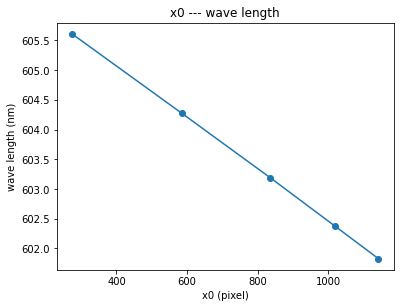

In [ ]:
spectrum_lims = [
  [1120, 1165],
  [990, 1040],
  [815, 860],
  [570, 610],
  [210, 310],
#  [240, 280]
]
wave_lengths = [
  601.8299,
  602.3757,
  603.1909,
  604.2716,
  605.6091,
  607.1996,
  609.0374,
  610.9030
]
plt.figure(figsize=(35, 10))
result_00 = []

for i, lims in enumerate(spectrum_lims):
    result = fit(spectrum_data.sel(motor_coordinate=465000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
    result['v'] = 0
    result['N'] = i+1
    result['wave_length'] = wave_lengths[i]
    result['long_x'] = spectrum_data.sel(motor_coordinate=465000).isel(x=int(result['x0'].values.tolist()))['long_x']
    plt.subplot(2, len(spectrum_lims), i+1)
    result['data'].plot(marker='.')
    result['fit'].plot()
    plt.title('N = {}'.format(i+1))
    plt.xlabel('pixels')
    plt.ylabel('intensity')
    result_00.append(result)
result_00 = xr.concat(result_00, dim='N')

plt.figure(figsize=[35, 10])
plt.subplot(2, i+1, i+2)
plt.plot(result_00['x0'], result_00['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')


## (v' - v") = (1 - 1)

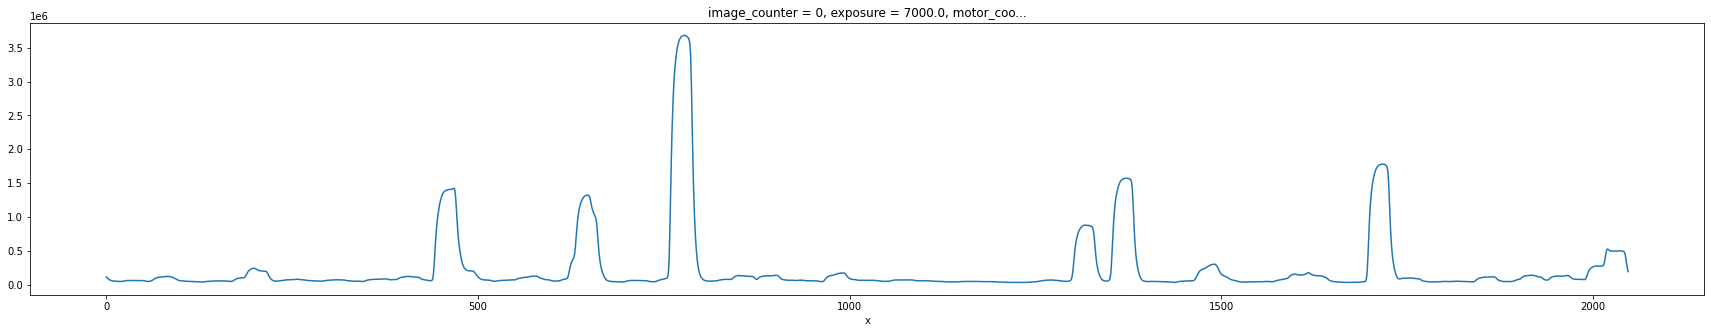

In [ ]:
plt.figure(figsize=(30, 5))
spectrum_data.sel(motor_coordinate=455000).plot()

Text(0, 0.5, 'wave length (nm)')

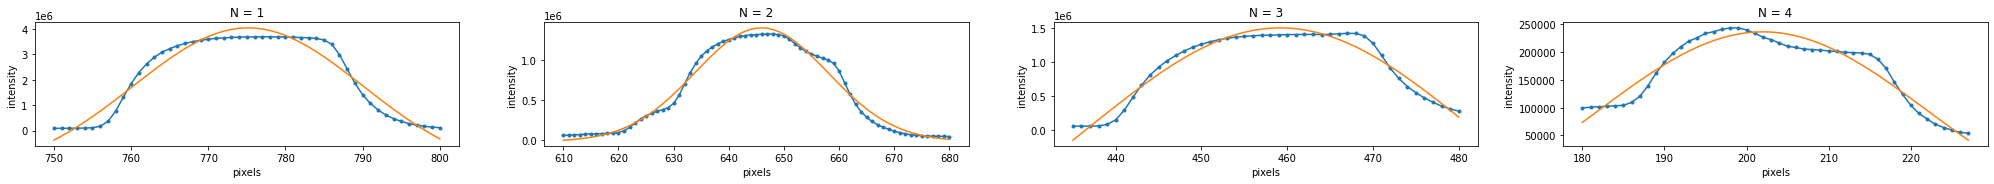

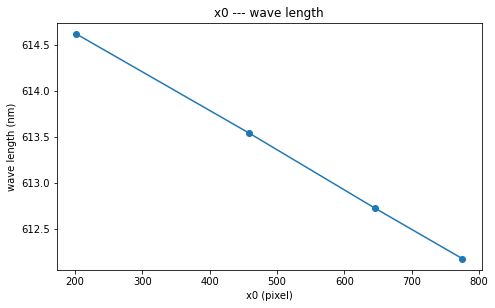

In [ ]:
spectrum_lims = [
  [750, 800],
  [610, 680],
  [435, 480],
  [180, 227],
]
wave_lengths = [
  612.1787,
  612.7246,
  613.5395,
  614.6186,
  615.9565
]
plt.figure(figsize=(35, 5))
result_11 = []

for i, lims in enumerate(spectrum_lims):
    result = fit(spectrum_data.sel(motor_coordinate=455000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
    result['v'] = 0
    result['N'] = i+1
    result['wave_length'] = wave_lengths[i]
    result['long_x'] = spectrum_data.sel(motor_coordinate=455000).isel(x=int(result['x0'].values.tolist()))['long_x']
    plt.subplot(2, len(spectrum_lims), i+1)
    result['data'].plot(marker='.')
    result['fit'].plot()
    plt.title('N = {}'.format(i+1))
    plt.xlabel('pixels')
    plt.ylabel('intensity')
    result_11.append(result)
result_11 = xr.concat(result_11, dim='N')

plt.figure(figsize=[35, 10])
plt.subplot(2, i+1, i+2)
plt.plot(result_11['x0'], result_11['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')

## (v' - v") = (2 - 2)

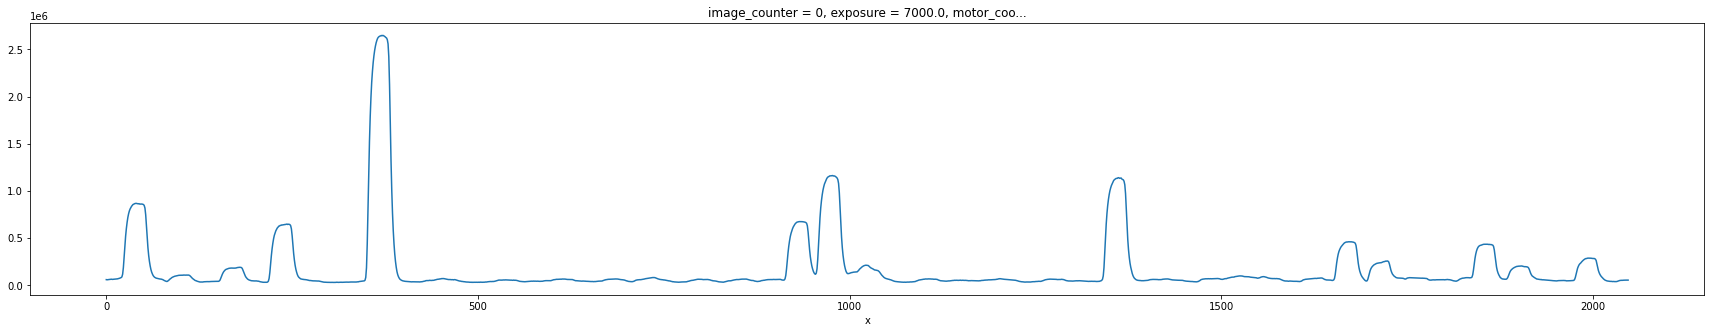

In [ ]:
plt.figure(figsize=(30, 5))
spectrum_data.sel(motor_coordinate=445000).plot()


Text(0, 0.5, 'wave length (nm)')

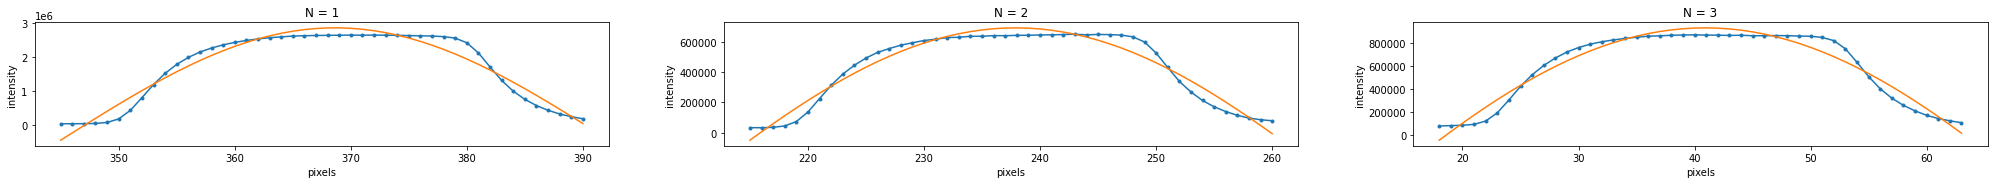

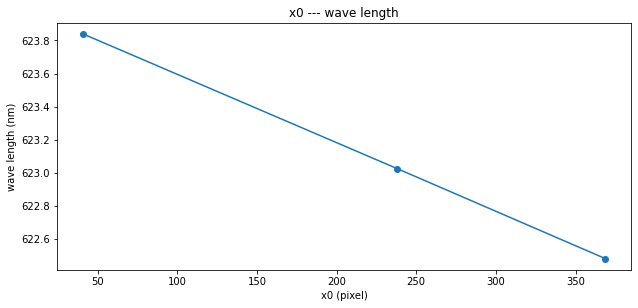

In [ ]:
spectrum_lims = [
  [345, 390],
  [215, 260],
  [18, 63],
]
wave_lengths = [
  622.4815,
  623.0258,
  623.8391,
  624.9150,
  626.2495,
  627.8369,
  629.6622,
  631.7233

]
plt.figure(figsize=(35, 5))
result_22 = []

for i, lims in enumerate(spectrum_lims):
    result = fit(spectrum_data.sel(motor_coordinate=445000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
    result['v'] = 0
    result['N'] = i+1
    result['wave_length'] = wave_lengths[i]
    result['long_x'] = spectrum_data.sel(motor_coordinate=445000).isel(x=int(result['x0'].values.tolist()))['long_x']
    plt.subplot(2, len(spectrum_lims), i+1)
    result['data'].plot(marker='.')
    result['fit'].plot()
    plt.title('N = {}'.format(i+1))
    plt.xlabel('pixels')
    plt.ylabel('intensity')
    result_22.append(result)
result_22 = xr.concat(result_22, dim='N')

plt.figure(figsize=[35, 10])
plt.subplot(2, i+1, i+2)
plt.plot(result_22['x0'], result_22['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')

# ピクセルを波長に変換

Text(0, 0.5, 'wavelength (nm)')

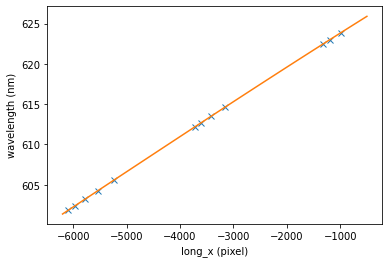

In [ ]:
wavelength = np.concatenate([result_00['wave_length'].values, result_11['wave_length'].values, result_22['wave_length'].values])
longx = np.concatenate([result_00['long_x'].values, result_11['long_x'].values, result_22['long_x'].values])

longx_to_wavelength_fun = np.poly1d(np.polyfit(longx, wavelength, 3))
x = np.linspace(-6200, -500, 100)

plt.plot(longx, wavelength, marker='x', linestyle='None')
plt.plot(x, longx_to_wavelength_fun(x))
plt.xlabel('long_x (pixel)')
plt.ylabel('wavelength (nm)')

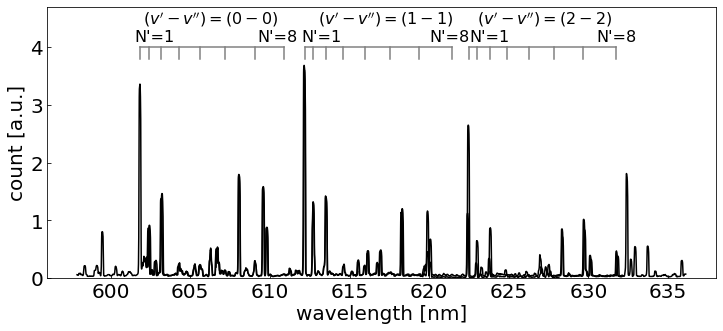

In [ ]:
plt.figure(figsize=(12, 5))
plt.xlabel('wavelength [nm]')
plt.ylabel('count [a.u.]')
plt.ylim(0, 4.7)
plt.rcParams['font.size'] = 20

for s in spectrum_data:
    plt.plot(s['wavelength'], s/1e6, f'k')

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

plt.plot([601.8299, 601.8299], [3.8, 4], color='gray')
plt.plot([602.3757, 602.3757], [3.8, 4], color='gray')
plt.plot([603.1909, 603.1909], [3.8, 4], color='gray')
plt.plot([604.2716, 604.2716], [3.8, 4], color='gray')
plt.plot([605.6091, 605.6091], [3.8, 4], color='gray')
plt.plot([607.1996, 607.1996], [3.8, 4], color='gray')
plt.plot([609.0374, 609.0374], [3.8, 4], color='gray')
plt.plot([610.9030, 610.9030], [3.8, 4], color='gray')
plt.plot([601.8299, 610.9030], [4, 4], color='gray')
plt.text(602, 4.4, "$(v'-v'')=(0-0)$", fontsize=16)
plt.text(601.5, 4.1, "N'=1", fontsize=16)
plt.text(609.2, 4.1, "N'=8", fontsize=16)

plt.plot([612.1787, 612.1787], [3.8, 4], color='gray')
plt.plot([612.7246, 612.7246], [3.8, 4], color='gray')
plt.plot([613.5395, 613.5395], [3.8, 4], color='gray')
plt.plot([614.6186, 614.6186], [3.8, 4], color='gray')
plt.plot([615.9565, 615.9565], [3.8, 4], color='gray')
plt.plot([617.5462, 617.5462], [3.8, 4], color='gray')
plt.plot([619.3812, 619.3812], [3.8, 4], color='gray')
plt.plot([621.4507, 621.4507], [3.8, 4], color='gray')
plt.plot([612.1787, 621.4507], [4, 4], color='gray')
plt.text(613, 4.4, "$(v'-v'')=(1-1)$", fontsize=16)
plt.text(612, 4.1, "N'=1", fontsize=16)
plt.text(620.0, 4.1, "N'=8", fontsize=16)

plt.plot([622.4815, 622.4815], [3.8, 4], color='gray')
plt.plot([623.0258, 623.0258], [3.8, 4], color='gray')
plt.plot([623.8391, 623.8391], [3.8, 4], color='gray')
plt.plot([624.9150, 624.9150], [3.8, 4], color='gray')
plt.plot([626.2495, 626.2495], [3.8, 4], color='gray')
plt.plot([627.8369, 627.8369], [3.8, 4], color='gray')
plt.plot([629.6622, 629.6622], [3.8, 4], color='gray')
plt.plot([631.7233, 631.7233], [3.8, 4], color='gray')
plt.plot([622.4815, 631.7233], [4, 4], color='gray')
plt.text(623, 4.4, "$(v'-v'')=(2-2)$", fontsize=16)
plt.text(622.5, 4.1, "N'=1", fontsize=16)
plt.text(630.5, 4.1, "N'=8", fontsize=16)

plt.savefig('/content/drive/MyDrive/研究室/images/analyze_12-17/spectrum', bbox_inches='tight')

# 数値積分

## (v' - v") = (0 - 0)

In [ ]:
func465000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=465000)['wavelength'], spectrum_data.sel(motor_coordinate=465000), kind='linear')
func460000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=460000)['wavelength'], spectrum_data.sel(motor_coordinate=460000), kind='linear')
func455000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=455000)['wavelength'], spectrum_data.sel(motor_coordinate=455000), kind='linear')
func450000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=450000)['wavelength'], spectrum_data.sel(motor_coordinate=450000), kind='linear')
func445000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=445000)['wavelength'], spectrum_data.sel(motor_coordinate=445000), kind='linear')
func440000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=440000)['wavelength'], spectrum_data.sel(motor_coordinate=440000), kind='linear')
func435000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=435000)['wavelength'], spectrum_data.sel(motor_coordinate=435000), kind='linear')

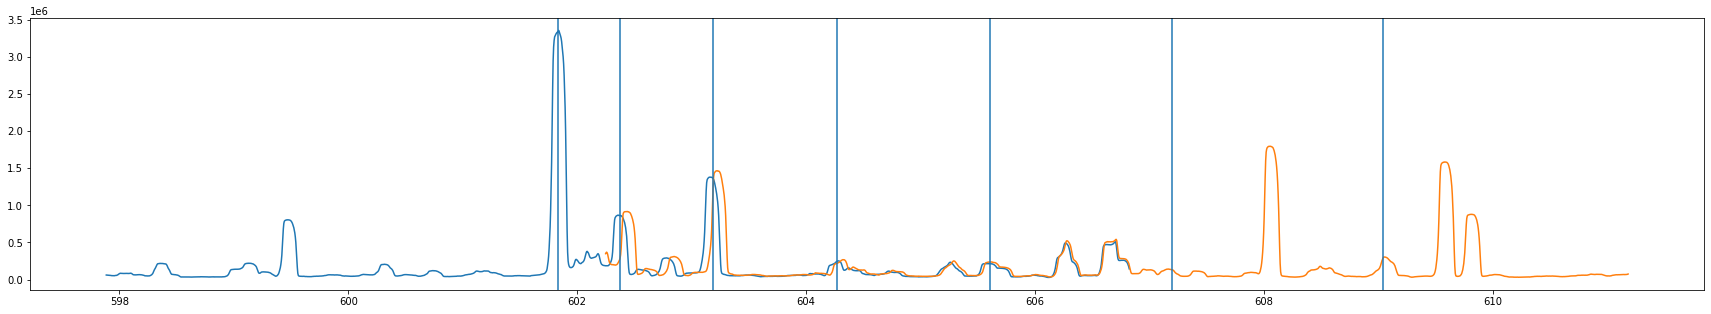

In [ ]:
plt.figure(figsize=(30, 5))
data = spectrum_data.sel(motor_coordinate=465000)
plt.plot(data['wavelength'], data)
data = spectrum_data.sel(motor_coordinate=460000)
plt.plot(data['wavelength'], data)
wave_lengths = [
  601.8299,
  602.3757,
  603.1909,
  604.2716,
  605.6091,
  607.1996,
  609.0374,
#  610.9030
]
for w in wave_lengths:
  plt.axvline(w)


In [ ]:
array = []
wave_lengths = [
  601.8299,
  602.3757,
  603.1909,
  604.2716,
  605.6091,
  607.1996,
  609.0374,
#  610.9030
]
args = [
  {"func": func465000, "start": 601.73, "end": 601.94, "N": 1},
  {"func": func465000, "start": 602.29, "end": 602.46, "N": 2},
  {"func": func465000, "start": 603.07, "end": 603.275, "N": 3},
  {"func": func465000, "start": 604.17, "end": 604.34, "N": 4},
  {"func": func465000, "start": 605.50, "end": 605.80, "N": 5},
  {"func": func460000, "start": 607.075, "end": 607.28, "N": 6},
  {"func": func460000, "start": 608.92, "end": 609.2, "N": 7},
]

for arg in args:
  array.append({
    "v": 0,
    "N": arg['N'],
    "wavelength": wave_lengths[arg['N'] - 1],
    "intensity": integrate.quad(arg['func'], arg['start'], arg['end'])
  })

Ns = np.fromiter(map(lambda a: a['N'], array), dtype=np.int)
intensities = np.fromiter(map(lambda a: a['intensity'][0], array), dtype=np.float)
wavelengths = np.fromiter(map(lambda a: a['wavelength'], array), dtype=np.float)
data_00 = xr.DataArray(intensities, dims=['N'], coords=[('N', Ns)])
data_00['v'] = 0
data_00 = data_00.assign_coords(wavelength=("N",  wavelengths))
data_00 = data_00.assign_coords(intensity=("N",  intensities))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


## (v' - v") = (1 - 1)

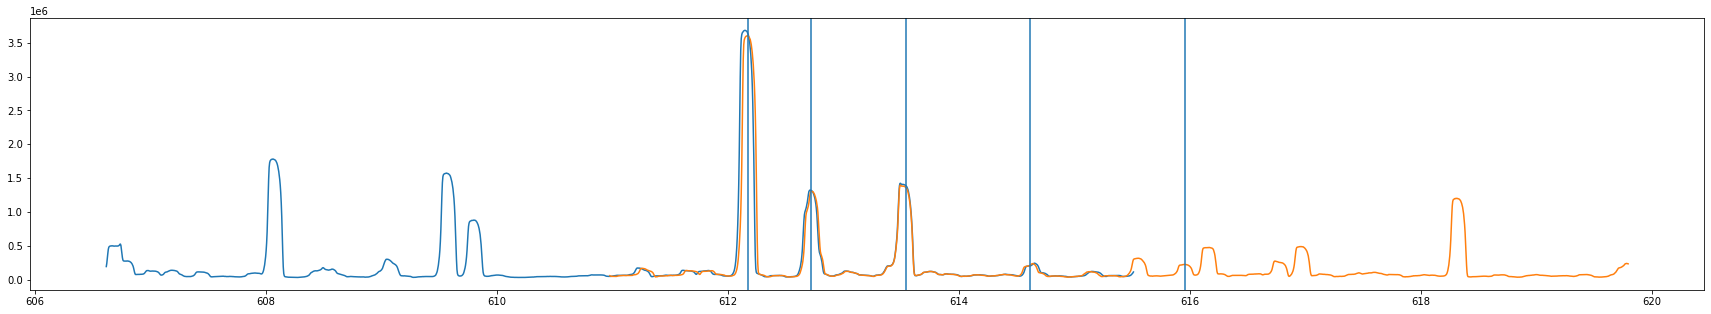

In [ ]:
plt.figure(figsize=(30, 5))
data = spectrum_data.sel(motor_coordinate=455000)
plt.plot(data['wavelength'], data)
data = spectrum_data.sel(motor_coordinate=450000)
plt.plot(data['wavelength'], data)
wave_lengths = [
  612.1787,
  612.7246,
  613.5395,
  614.6186,
  615.9565
]
for w in wave_lengths:
  plt.axvline(w)

In [ ]:
array = []
wave_lengths = [
  612.1787,
  612.7246,
  613.5395,
  614.6186,
  615.9565
]
args = [
  {"func": func450000, "start": 612.05, "end": 612.27, "N": 1},
  {"func": func450000, "start": 612.6, "end": 612.85, "N": 2},
  {"func": func450000, "start": 613.425, "end": 613.62, "N": 3},
  {"func": func450000, "start": 614.52, "end": 614.75, "N": 4},
  {"func": func450000, "start": 615.85, "end": 616.05, "N": 5},
]

for arg in args:
  array.append({
    "v": 1,
    "N": arg['N'],
    "wavelength": wave_lengths[arg['N'] - 1],
    "intensity": integrate.quad(arg['func'], arg['start'], arg['end'])
  })

Ns = np.fromiter(map(lambda a: a['N'], array), dtype=np.int)
intensities = np.fromiter(map(lambda a: a['intensity'][0], array), dtype=np.float)
wavelengths = np.fromiter(map(lambda a: a['wavelength'], array), dtype=np.float)
data_11 = xr.DataArray(intensities, dims=['N'], coords=[('N', Ns)])
data_11['v'] = 1
data_11 = data_11.assign_coords(wavelength=("N",  wavelengths))
data_11 = data_11.assign_coords(intensity=("N",  intensities))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


## (v' - v") = (2 - 2)

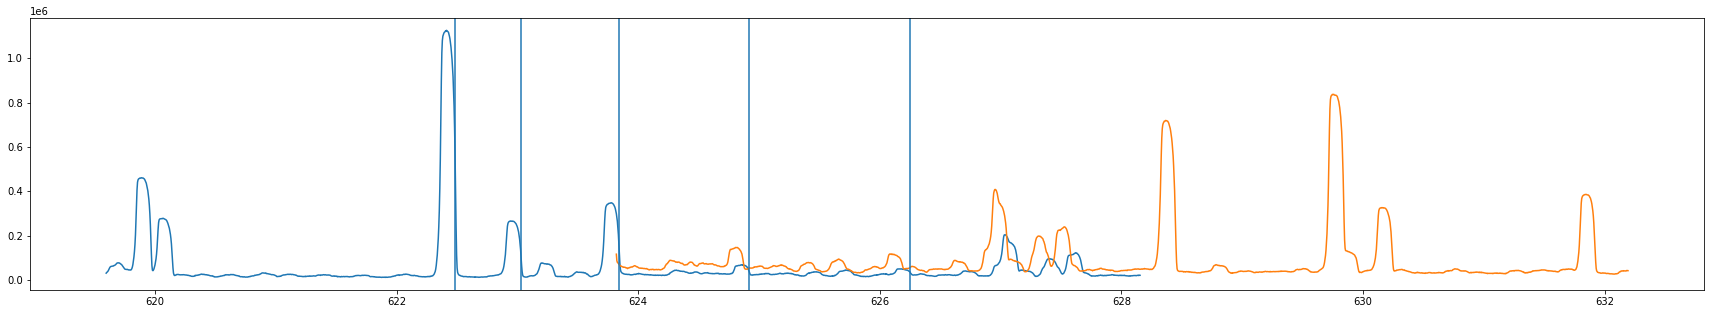

In [ ]:
plt.figure(figsize=(30, 5))
data = spectrum_data.sel(motor_coordinate=440000)
plt.plot(data['wavelength'], data)
data = spectrum_data.sel(motor_coordinate=435000)
plt.plot(data['wavelength'], data)
wave_lengths = [
  622.4815,
  623.0258,
  623.8391,
  624.9150,
  626.2495,
#  627.8369,
#  629.6622,
#  631.7233
]
for w in wave_lengths:
  plt.axvline(w)


In [ ]:
array = []
wave_lengths = [
  622.4815,
  623.0258,
  623.8391,
  624.9150,
  626.2495,
#  627.8369,
#  629.6622,
#  631.7233
]
args = [
  {"func": func440000, "start": 622.33, "end": 622.52, "N": 1},
  {"func": func440000, "start": 622.86, "end": 623.05, "N": 2},
  {"func": func440000, "start": 623.67, "end": 623.875, "N": 3},
  {"func": func440000, "start": 624.77, "end": 624.93, "N": 4},
  {"func": func440000, "start": 626.1, "end": 626.28, "N": 5},
]

for arg in args:
  array.append({
    "v": 2,
    "N": arg['N'],
    "wavelength": wave_lengths[arg['N'] - 1],
    "intensity": integrate.quad(arg['func'], arg['start'], arg['end'])
  })

Ns = np.fromiter(map(lambda a: a['N'], array), dtype=np.int)
intensities = np.fromiter(map(lambda a: a['intensity'][0], array), dtype=np.float)
wavelengths = np.fromiter(map(lambda a: a['wavelength'], array), dtype=np.float)
data_22 = xr.DataArray(intensities, dims=['N'], coords=[('N', Ns)])
data_22['v'] = 2
data_22 = data_22.assign_coords(wavelength=("N",  wavelengths))
data_22 = data_22.assign_coords(intensity=("N",  intensities))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


# ファイルに保存

In [ ]:
data_00.to_netcdf(join(data_path, '/content/drive/MyDrive/研究室/myLeprecon/niihama/analyze_12-17/data_00.nc'))
data_11.to_netcdf(join(data_path, '/content/drive/MyDrive/研究室/myLeprecon/niihama/analyze_12-17/data_11.nc'))
data_22.to_netcdf(join(data_path, '/content/drive/MyDrive/研究室/myLeprecon/niihama/analyze_12-17/data_22.nc'))


In [ ]:
xr.load_dataarray('/content/drive/MyDrive/研究室/myLeprecon/niihama/analyze_12-17/data_00.nc')

<xarray.DataArray (N: 7)>
array([420837.7006732 , 109578.14023825, 176926.71479757,  32210.88973023,
        47883.46254319,  21732.15146306,  47643.33604267])
Coordinates:
  * N           (N) int64 1 2 3 4 5 6 7
    v           int64 0
    wavelength  (N) float64 601.8 602.4 603.2 604.3 605.6 607.2 609.0
    intensity   (N) float64 4.208e+05 1.096e+05 ... 2.173e+04 4.764e+04